In [1]:
##########################################################################
import numpy as np
from numba import njit
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy import ndimage
import os
import time

from emcee import EnsembleSampler
import corner

# Convert from arcsec and deg to radians
from galario import arcsec, deg
from galario.double import chi2Image, sampleImage, get_image_size
from uvplot import COLUMNS_V0

from uvplot import UVTable
from IPython.display import display, HTML
from galario_2D_model_functions import model_registry
##########################################################################

In [2]:
##################### MODIFY HERE #####################
target = 'CQ_Tau'

uvtable_filename = f'../data/{target}_galario_uvtable.txt'

# Select model
selected_model = "2rings_2arcs"

In [3]:
##################################
#####   IMPORT THE UVTABLE   #####
##################################

print('Importing uvtable')
wle = np.loadtxt(uvtable_filename, skiprows=2, max_rows=1)
u, v, Re, Im, w = np.require(np.loadtxt(uvtable_filename, skiprows=4, unpack=True), requirements='C')

Importing uvtable


In [4]:
########################################
#####   DETERMINE THE IMAGE SIZE   #####
########################################

# compute the optimal image size (nxy=number of pixels, dxy=pixel size in radians)
nxy, dxy = get_image_size(u, v, verbose=True, f_min=5., f_max=2.5)

# define the image grid in radians
xarr = np.linspace(-nxy/2*dxy, nxy/2*dxy, nxy)
yarr = np.linspace(-nxy/2*dxy, nxy/2*dxy, nxy)
x,y = np.meshgrid(xarr, yarr)

dxy:5.788260e-03arcsec	nxy_MRS:8192
nxy_MRS: matrix size to have FOV > f_min * MRS, where f_min:5.0 and MRS:9.483484e+00arcsec


In [5]:
model_info = model_registry[selected_model]
model_function = model_info["function"]
base_parameters = model_info["parameters"]
param_labels = model_info["labels"]

params = [param for param in base_parameters]
params.extend(["inc", "PA", "dRA", "dDec"])
ndim = len(params)

In [6]:
params

['f1',
 'r1',
 'sigma1',
 'f2',
 'r2',
 'sigma2',
 'f_arc1',
 'r_arc1',
 'sigmar_arc1',
 'phi_arc1',
 'sigmaphi_arc1',
 'f_arc2',
 'r_arc2',
 'sigmar_arc2',
 'phi_arc2',
 'sigmaphi_arc2',
 'inc',
 'PA',
 'dRA',
 'dDec']

In [7]:
param_dict = {}

param_dict['f1'] = 10.55
param_dict['r1'] = 0.28
param_dict['sigma1'] = 0.1

param_dict['f2'] = 9.27
param_dict['r2'] = 0.48
param_dict['sigma2'] = 0.18

param_dict['f_arc1'] = 10.4
param_dict['r_arc1'] = 0.3
param_dict['sigmar_arc1'] = 0.08
param_dict['phi_arc1'] = 10
param_dict['sigmaphi_arc1'] = 40

param_dict['f_arc2'] = 10.4
param_dict['r_arc2'] = 0.3
param_dict['sigmar_arc2'] = 0.08
param_dict['phi_arc2'] = 160
param_dict['sigmaphi_arc2'] = 30

param_dict['inc'] = 35.
param_dict['PA'] = 55.
param_dict['dRA'] = 0.0
param_dict['dDec'] = 0.0

In [8]:
# Convert specific parameters to required units
for key in ["sigma0", "sigma1", "sigma2", "sigma3", "sigma4", "sigma5", "sigma6", 
            "r1", "r2", "r3", "r4", "r5", "r6", 
            "r_arc1", "r_arc2", "r_arc3", "r_arc4", "r_arc5", "r_arc6",
            "sigmar_arc1", "sigmar_arc2", "sigmar_arc3", "sigmar_arc4", "sigmar_arc5", "sigmar_arc6", 
            "dRA", "dDec"]:
    if key in param_dict:
        param_dict[key] *= arcsec

for key in ["sigmaphi_arc1", "sigmaphi_arc2", "sigmaphi_arc3", "sigmaphi_arc4", "sigmaphi_arc5", "sigmaphi_arc6",
            "inc", "PA"]:
    if key in param_dict:
        param_dict[key] *= deg

for key in ["phi_arc1", "phi_arc2", "phi_arc3", "phi_arc4", "phi_arc5", "phi_arc6"]:
    if key in param_dict:
        param_dict[key] = (90+param_dict[key]) * deg

for key in ["f0", "f1", "f2", "f3", "f4", "f5", "f6",
            "f_arc1", "f_arc2", "f_arc3", "f_arc4", "f_arc5", "f_arc6"]:
    if key in param_dict:
        param_dict[key] = 10.0**param_dict[key] * dxy**2

# Extract the necessary parameters for chi2Image
inc = param_dict["inc"]
PA = param_dict["PA"]
dRA = param_dict["dRA"]
dDec = param_dict["dDec"]
funtion_param_dict = {key: val for key, val in param_dict.items() if key not in ["inc", "PA", "dRA", "dDec"]}
funtion_param_dict["inc_rad"] = inc

In [9]:
model_image = model_function(x,y,**funtion_param_dict)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


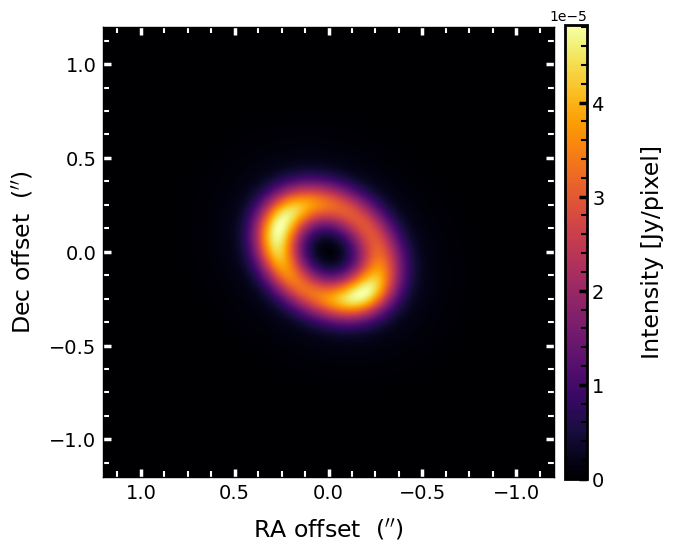

In [10]:
fig= plt.figure(figsize=(7,5.9))
ax =fig.add_subplot(111)

rotate_img = ndimage.rotate(model_image, -PA/deg, reshape=False)
plt.imshow(rotate_img, cmap = 'inferno', extent=[nxy/2*dxy/arcsec, -nxy/2*dxy/arcsec, -nxy/2*dxy/arcsec, nxy/2*dxy/arcsec],origin='lower')

cbar = plt.colorbar(pad=0.02)
cbar.outline.set_linewidth(2)
cbar.ax.tick_params(which='major', labelsize=14,width=2.5, length=6,direction='in')
cbar.ax.tick_params(which='minor', labelsize=14,width=1.5, length=4,direction='in')
cbar.set_label('Intensity [Jy/pixel]', fontsize = 17, labelpad=26)
cbar.ax.minorticks_on()

lim = 1.2
ax.set_xlim(lim,-lim)
ax.set_ylim(-lim,lim)

index_ticks = 0.5
ax.xaxis.set_major_locator(MultipleLocator(index_ticks))
ax.xaxis.set_minor_locator(MultipleLocator(index_ticks/4))
ax.yaxis.set_major_locator(MultipleLocator(index_ticks))
ax.yaxis.set_minor_locator(MultipleLocator(index_ticks/4)) 
ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=14, pad=5,width=2.5, length=6,direction='in',color='w')
ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=14, pad=5,width=1.5, length=4,direction='in',color='w')
ax.set_xlabel('RA offset  ($^{\prime\prime}$)', fontsize = 17, labelpad=10)
ax.set_ylabel('Dec offset  ($^{\prime\prime}$)', fontsize = 17, labelpad=10)

for side in ax.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax.spines[side].set_linewidth(1)

In [11]:
vis_mod = sampleImage(model_image, dxy, u, v, PA=PA, dRA=dRA, dDec=dDec, origin='lower')

Masking 0 uv bins
Masking 0 uv bins


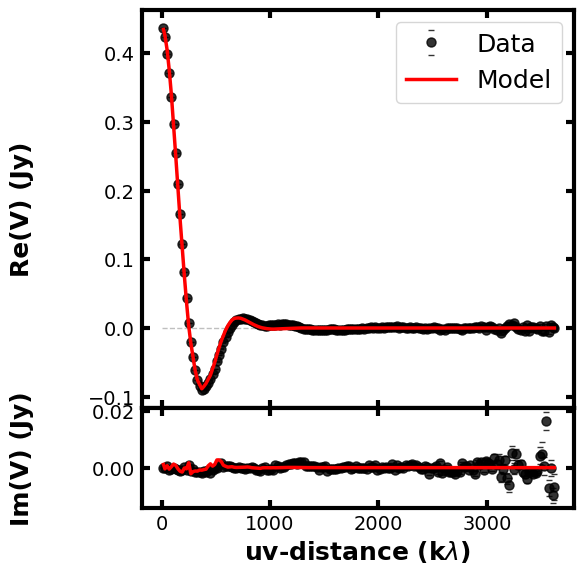

In [12]:
uvbin_size = 20e3     # uv-distance bin, units: wle

# observations uv-plot
uv = UVTable(uvtable=[u*wle, v*wle, Re, Im, w], wle=wle, columns=COLUMNS_V0)
uv.apply_phase(-dRA, -dDec)         # center the source on the phase center
uv.deproject(inc, PA)
axes = uv.plot(linestyle='.', color='k', label='Data', uvbin_size=uvbin_size, linewidth=1, alpha=0.8)

# model uv-plot
uv_mod = UVTable(uvtable=[u*wle, v*wle, vis_mod.real, vis_mod.imag, w], wle=wle, columns=COLUMNS_V0)
uv_mod.apply_phase(-dRA, -dDec)     # center the source on the phase center
uv_mod.deproject(inc, PA)
uv_mod.plot(axes=axes, linestyle='-', color='r', label='Model', yerr=False, uvbin_size=uvbin_size)

axes[0].hlines(0,0,3000, linewidth=1, alpha=0.5, color='gray', linestyle='dashed')
axes[1].hlines(0,0,3000, linewidth=1, alpha=0.5, color='gray', linestyle='dashed')


axes[0].legend(fontsize=18, frameon=True)
for side in axes[0].spines.keys():  # 'top', 'bottom', 'left', 'right'
    axes[0].spines[side].set_linewidth(3)

for side in axes[1].spines.keys():  # 'top', 'bottom', 'left', 'right'
    axes[1].spines[side].set_linewidth(3)
axes[0].tick_params(which='both',right=True,top=True, width=3, length=6,labelsize=14, direction='in',pad=5)
axes[1].tick_params(which='both',right=True,top=True, width=3, length=6,labelsize=14, direction='in',pad=5)
